<a href="https://colab.research.google.com/github/anniiisshaa/Meesho-RTO-prediction/blob/main/Meesho_RTO_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 🛍️ Meesho RTO Analysis and Prediction System (SQL + Python + ML)
This project analyzes product returns (RTOs) using SQL + ML, based on real order-level Meesho data.



##Upload and Load Data

In [2]:
import pandas as pd

# Replace with your file names after upload
df1 = pd.read_csv("/content/meesho ForwardReports.csv")
df2 = pd.read_csv("/content/meesho Orders Aug.csv")

df1.head()

,order_date,sub_order_num,order_status,state,pin,gst_amount,meesho_price,shipping_charges_total,price
0,2022-08-30,381809810413_1,Shipped,Jammu & Kashmir,180006,66.68,1400,121,1521
1,2022-08-10,940712900368_1,rto,Uttar Pradesh,208014,69.58,1461,114,1575
2,2022-08-03,322259568161_1,Delivered,Telangana,509001,64.30,1350,108,1440
3,2022-08-27,475133679575_1,Cancelled,Jammu & Kashmir,182101,98.96,2078,0,2078
4,2022-08-04,493966375185_1,rto,Odisha,760001,64.30,1350,108,1458


In [3]:
df2.head()

,Reason for Credit Entry,Sub Order No,Order Date,Customer State,Product Name,SKU,Size,Quantity,Supplier Listed Price (Incl. GST + Commission),Supplier Discounted Price (Incl GST and Commision)
0,DELIVERED,406826346276_1,2022-08-01,Rajasthan,FIVESTAR Georgette Lehengha Choli with Inner C...,6326,Semi Stitched,1,1910.0,1910.0
1,CANCELLED,216649987717_1,2022-08-02,Andhra Pradesh,Beautiful pure lakhnovi long kurta embroidery ...,Kb 201,XXL,1,1500.0,1500.0
2,DELIVERED,184970118893_1,2022-08-02,Karnataka,PARTY WEAR BEAUTIFUL LOOK FANCY EMBROIDERY AN...,hk 1446,Free Size,1,1561.0,1561.0
3,RTO_COMPLETE,916538974169_1,2022-08-02,Assam,FIVESTAR Designer Suit On Havy Gorgette febric...,1101 black,Semi Stitched,1,1749.0,1749.0
4,DELIVERED,528661643961_1,2022-08-02,West Bengal,stlish dress,mk -6114,XL,1,750.0,750.0


##🔄 Step 2: Merge Both Datasets on Sub Order Number

In [4]:

# Standardize column names
df1.rename(columns={'sub_order_num': 'Sub Order No'}, inplace=True)
merged_df = pd.merge(df2, df1, on='Sub Order No', how='inner')
merged_df.shape

(133, 18)

In [5]:
merged_df.head()

,Reason for Credit Entry,Sub Order No,Order Date,Customer State,Product Name,SKU,Size,Quantity,Supplier Listed Price (Incl. GST + Commission),Supplier Discounted Price (Incl GST and Commision),order_date,order_status,state,pin,gst_amount,meesho_price,shipping_charges_total,price
0,DELIVERED,406826346276_1,2022-08-01,Rajasthan,FIVESTAR Georgette Lehengha Choli with Inner C...,6326,Semi Stitched,1,1910.0,1910.0,2022-08-01,Delivered,Rajasthan,324008,97.62,2050,0,2050
1,DELIVERED,184970118893_1,2022-08-02,Karnataka,PARTY WEAR BEAUTIFUL LOOK FANCY EMBROIDERY AN...,hk 1446,Free Size,1,1561.0,1561.0,2022-08-02,Delivered,Karnataka,560001,74.34,1561,108,1651
2,RTO_COMPLETE,916538974169_1,2022-08-02,Assam,FIVESTAR Designer Suit On Havy Gorgette febric...,1101 black,Semi Stitched,1,1749.0,1749.0,2022-08-02,rto,Assam,782435,88.62,1861,0,1861
3,DELIVERED,528661643961_1,2022-08-02,West Bengal,stlish dress,mk -6114,XL,1,750.0,750.0,2022-08-02,Return,West Bengal,700061,35.72,750,79,829
4,RTO_COMPLETE,261363877240_1,2022-08-02,Uttar Pradesh,Heavy faux georgette with embroidery work with...,Ad 009 a,XXL,1,1500.0,1500.0,2022-08-02,rto,Uttar Pradesh,247001,71.44,1500,110,1610


In [6]:
# Recreate the is_rto column
merged_df['is_rto'] = merged_df['Reason for Credit Entry'].apply(lambda x: 1 if x == 'RTO_COMPLETE' else 0)



## 🧮 Step 3: Run SQL Queries on Merged Data

In [7]:
import sqlite3

# Create SQLite in-memory database
conn = sqlite3.connect(":memory:")
merged_df.to_sql("orders", conn, index=False)


133

📌 Query 1: RTO Count by State

In [8]:
pd.read_sql_query("""
SELECT [Customer State], COUNT(*) AS rto_count
FROM orders
WHERE [Reason for Credit Entry] = 'RTO_COMPLETE'
GROUP BY [Customer State]
ORDER BY rto_count DESC
""", conn)


,Customer State,rto_count
0,Andhra Pradesh,6
1,Uttar Pradesh,2
2,Telangana,2
3,Kerala,2
4,Delhi,2
5,Bihar,2
6,seoni,1
7,Tamil Nadu,1
8,Odisha,1
9,Mumbai,1


In [9]:
pd.read_sql_query("""
SELECT is_rto, ROUND(AVG([Supplier Listed Price (Incl. GST + Commission)]), 2) AS avg_price
FROM orders
GROUP BY is_rto
""", conn)


,is_rto,avg_price
0,0,1246.99
1,1,1285.87


📌 Query 3: Product Sizes with Most RTOs

In [10]:
pd.read_sql_query("""
SELECT Size, COUNT(*) AS rto_count
FROM orders
WHERE [Reason for Credit Entry] = 'RTO_COMPLETE'
GROUP BY Size
ORDER BY rto_count DESC
""", conn)


,Size,rto_count
0,Free Size,10
1,XXL,3
2,XL,3
3,Semi Stitched,3
4,M,3
5,L,1


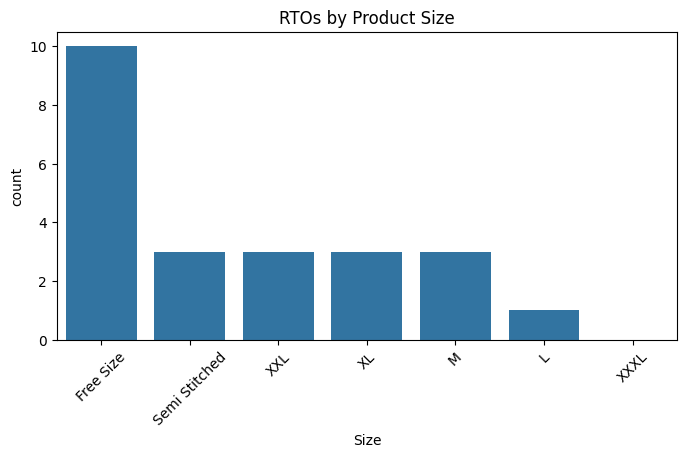

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# RTOs by Size
plt.figure(figsize=(8,4))
sns.countplot(data=merged_df[merged_df['is_rto'] == 1], x='Size', order=merged_df['Size'].value_counts().index)
plt.title("RTOs by Product Size")
plt.xticks(rotation=45)
plt.show()


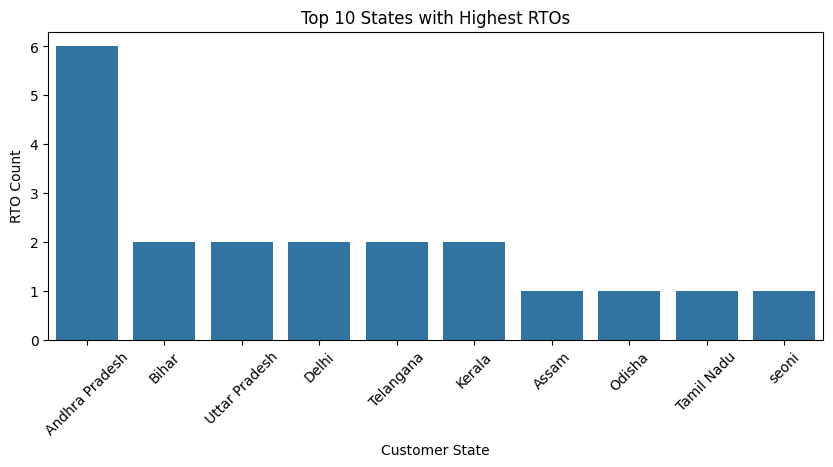

In [12]:
# RTOs by State
top_states = merged_df[merged_df['is_rto'] == 1]['Customer State'].value_counts().head(10)
plt.figure(figsize=(10,4))
sns.barplot(x=top_states.index, y=top_states.values)
plt.title("Top 10 States with Highest RTOs")
plt.ylabel("RTO Count")
plt.xticks(rotation=45)
plt.show()


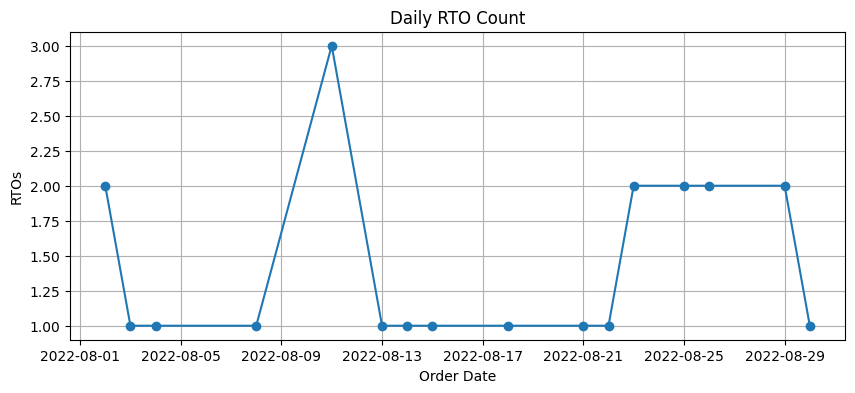

In [13]:
# Format date if not done already
merged_df['Order Date'] = pd.to_datetime(merged_df['Order Date'])
merged_df['order_day'] = merged_df['Order Date'].dt.date

# Plot RTO trend
import matplotlib.pyplot as plt
import seaborn as sns

daily_rto = merged_df[merged_df['is_rto'] == 1].groupby('order_day').size()
plt.figure(figsize=(10,4))
daily_rto.plot(kind='line', marker='o')
plt.title("Daily RTO Count")
plt.xlabel("Order Date")
plt.ylabel("RTOs")
plt.grid(True)
plt.show()


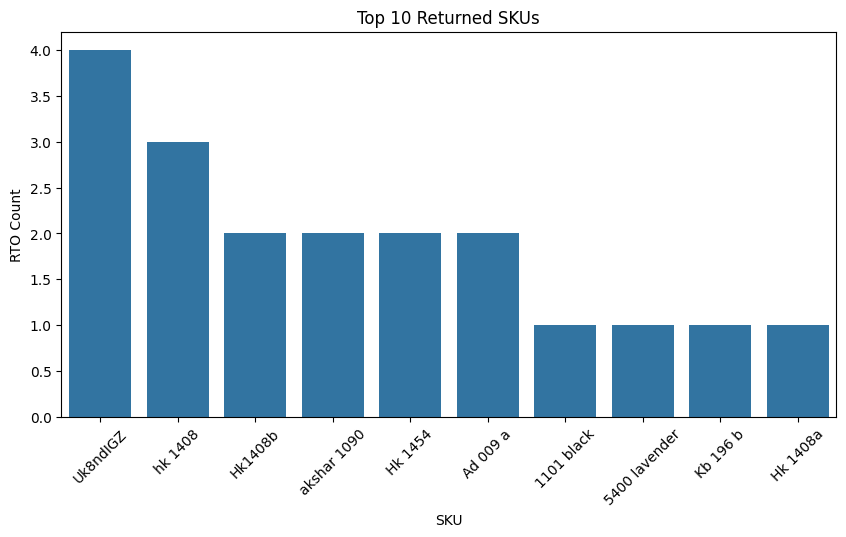

In [14]:
top_skus = merged_df[merged_df['is_rto'] == 1]['SKU'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_skus.index, y=top_skus.values)
plt.title("Top 10 Returned SKUs")
plt.ylabel("RTO Count")
plt.xticks(rotation=45)
plt.show()


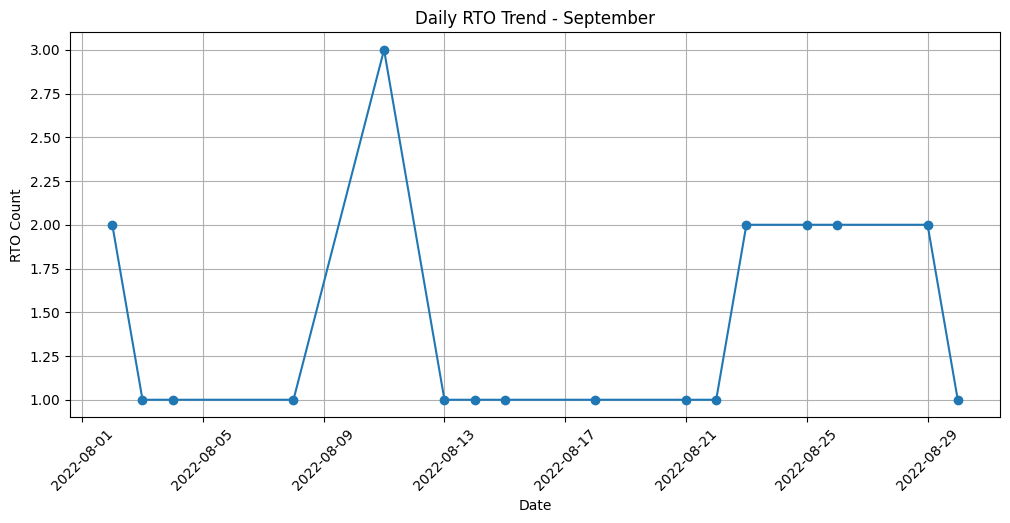

In [15]:
merged_df['Order Date'] = pd.to_datetime(merged_df['Order Date'])
merged_df['order_day'] = merged_df['Order Date'].dt.date

daily_rto = merged_df[merged_df['is_rto'] == 1].groupby('order_day').size()

plt.figure(figsize=(12, 5))
daily_rto.plot(marker='o', linestyle='-')
plt.title("Daily RTO Trend - September")
plt.xlabel("Date")
plt.ylabel("RTO Count")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


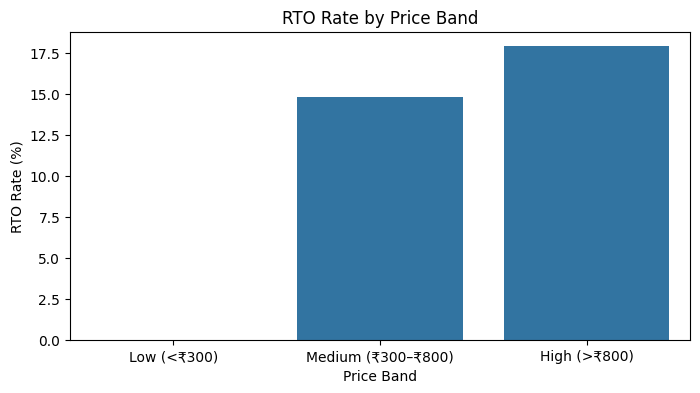

In [16]:
def get_price_band(p):
    if p < 300:
        return "Low (<₹300)"
    elif p <= 800:
        return "Medium (₹300–₹800)"
    else:
        return "High (>₹800)"

merged_df['price_band'] = merged_df['Supplier Listed Price (Incl. GST + Commission)'].apply(get_price_band)

price_rto = merged_df.groupby('price_band')['is_rto'].mean().reset_index()
price_rto['is_rto'] = price_rto['is_rto'] * 100

plt.figure(figsize=(8, 4))
sns.barplot(data=price_rto, x='price_band', y='is_rto', order=['Low (<₹300)', 'Medium (₹300–₹800)', 'High (>₹800)'])
plt.title("RTO Rate by Price Band")
plt.ylabel("RTO Rate (%)")
plt.xlabel("Price Band")
plt.show()


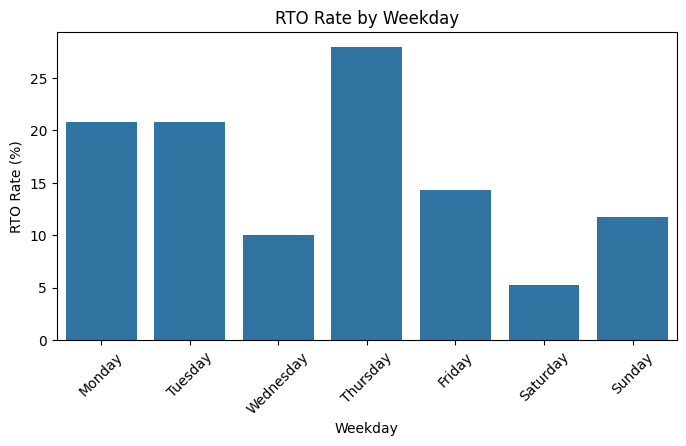

In [17]:
merged_df['order_weekday'] = merged_df['Order Date'].dt.day_name()

weekday_rto = merged_df.groupby('order_weekday')['is_rto'].mean().reset_index()
weekday_rto['is_rto'] = weekday_rto['is_rto'] * 100

plt.figure(figsize=(8, 4))
sns.barplot(data=weekday_rto, x='order_weekday', y='is_rto', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("RTO Rate by Weekday")
plt.ylabel("RTO Rate (%)")
plt.xlabel("Weekday")
plt.xticks(rotation=45)
plt.show()


##PREDICTION MODEL

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Encode features
X = pd.get_dummies(merged_df[['Size', 'Customer State', 'Quantity']], drop_first=True)
y = merged_df['is_rto']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train model
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.82      0.84      0.83        32
           1       0.29      0.25      0.27         8

    accuracy                           0.72        40
   macro avg       0.55      0.55      0.55        40
weighted avg       0.71      0.72      0.72        40



In [19]:
X.columns.tolist()


['Quantity',
 'Size_L',
 'Size_M',
 'Size_Semi Stitched',
 'Size_XL',
 'Size_XXL',
 'Size_XXXL',
 'Customer State_Arunachal Pradesh',
 'Customer State_Assam',
 'Customer State_Bihar',
 'Customer State_Chandigarh',
 'Customer State_Chhattisgarh',
 'Customer State_Delhi',
 'Customer State_Goa',
 'Customer State_Gujarat',
 'Customer State_Haryana',
 'Customer State_Himachal Pradesh',
 'Customer State_Jammu & Kashmir',
 'Customer State_Karnataka',
 'Customer State_Kerala',
 'Customer State_MAHARASHTRA',
 'Customer State_Madhya Pradesh',
 'Customer State_Maharashtra',
 'Customer State_Mumbai',
 'Customer State_Odisha',
 'Customer State_Others',
 'Customer State_Punjab',
 'Customer State_Rajasthan',
 'Customer State_State Bank Of India',
 'Customer State_Tamil Nadu',
 'Customer State_Telangana',
 'Customer State_Up ',
 'Customer State_Uttar Pradesh',
 'Customer State_Uttarakhand',
 'Customer State_West Bengal',
 'Customer State_West Bengal ',
 'Customer State_odisha',
 'Customer State_punjab

In [32]:
# Create an empty input row
test_input = pd.DataFrame(columns=X.columns)
test_input.loc[0] = 0  # Fill all with 0 initially

# Set input features
test_input.at[0, 'Quantity'] = 1
test_input.at[0, 'Size_XL'] = 1
test_input.at[0, 'Customer State_Karnataka'] = 1

# Predict
prediction = model.predict(test_input)[0]
print(" Prediction:", "RTO" if prediction == 1 else "Not RTO")


 Prediction: Not RTO


In [33]:

# Set input features
test_input.at[0, 'Quantity'] = 2
test_input.at[0, 'Size_M'] = 1
test_input.at[0, 'Customer State_Bihar'] = 1

# Predict
prediction = model.predict(test_input)[0]
print(" Prediction:", "RTO" if prediction == 1 else "Not RTO")

 Prediction: RTO


##CASE STUDY
Q. What is a Case Study?

A case study is a structured business analysis like:
“Why is the RTO rate high in certain product categories or states, and what can Meesho do to reduce it?”

We are using SQL, charts, and storytelling to answer why something is happening, not just what.

In [22]:
pd.read_sql_query("""
SELECT [Product Name], Size,
  COUNT(*) AS total_orders,
  SUM(CASE WHEN [Reason for Credit Entry] = 'RTO_COMPLETE' THEN 1 ELSE 0 END) AS rto_count,
  ROUND(100.0 * SUM(CASE WHEN [Reason for Credit Entry] = 'RTO_COMPLETE' THEN 1 ELSE 0 END) / COUNT(*), 2) AS rto_rate
FROM orders
GROUP BY [Product Name], Size
ORDER BY rto_rate DESC
LIMIT 10;
""", conn)


,Product Name,Size,total_orders,rto_count,rto_rate
0,Beautiful maska cotton kurta set with muslin c...,L,1,1,100.0
1,FIVESTAR wedding special occasions Lehengha ch...,Semi Stitched,1,1,100.0
2,Fancy organza dress with kamar belt and hairbelt,M,1,1,100.0
3,Heavy faux georgette with embroidery work with...,XL,1,1,100.0
4,FIVESTAR Designer Suit On Havy Gorgette febric...,Semi Stitched,2,1,50.0
5,Heavy Soft Butterfly Net With Rose Flower Patt...,XL,2,1,50.0
6,Heavy faux georgette with embroidery work with...,XXL,2,1,50.0
7,Kalamkari print full flair narkali sut set,M,2,1,50.0
8,Fancy look beautiful embroidery work kurti bot...,XXL,8,2,25.0
9,top & bottom set,XL,4,1,25.0


## 1. High RTO Product Segments
Case: “Which product sizes or SKUs are driving most of the RTOs?”

What are we Analyzing:

RTO count by Size, Product Name, and SKU

RTO% = RTO_COMPLETE / Total orders for that product

In [23]:
pd.read_sql_query("""
SELECT [Product Name], Size,
  COUNT(*) AS total_orders,
  SUM(CASE WHEN [Reason for Credit Entry] = 'RTO_COMPLETE' THEN 1 ELSE 0 END) AS rto_count,
  ROUND(100.0 * SUM(CASE WHEN [Reason for Credit Entry] = 'RTO_COMPLETE' THEN 1 ELSE 0 END) / COUNT(*), 2) AS rto_rate
FROM orders
GROUP BY [Product Name], Size
ORDER BY rto_rate DESC
LIMIT 10;
""", conn)


,Product Name,Size,total_orders,rto_count,rto_rate
0,Beautiful maska cotton kurta set with muslin c...,L,1,1,100.0
1,FIVESTAR wedding special occasions Lehengha ch...,Semi Stitched,1,1,100.0
2,Fancy organza dress with kamar belt and hairbelt,M,1,1,100.0
3,Heavy faux georgette with embroidery work with...,XL,1,1,100.0
4,FIVESTAR Designer Suit On Havy Gorgette febric...,Semi Stitched,2,1,50.0
5,Heavy Soft Butterfly Net With Rose Flower Patt...,XL,2,1,50.0
6,Heavy faux georgette with embroidery work with...,XXL,2,1,50.0
7,Kalamkari print full flair narkali sut set,M,2,1,50.0
8,Fancy look beautiful embroidery work kurti bot...,XXL,8,2,25.0
9,top & bottom set,XL,4,1,25.0


##2. RTO by Customer State

In [24]:
pd.read_sql_query("""
SELECT [Customer State],
  COUNT(*) AS total_orders,
  SUM(CASE WHEN is_rto = 1 THEN 1 ELSE 0 END) AS rto_count,
  ROUND(100.0 * SUM(CASE WHEN is_rto = 1 THEN 1 ELSE 0 END)/COUNT(*), 2) AS rto_rate
FROM orders
GROUP BY [Customer State]
ORDER BY rto_rate DESC;
""", conn)


,Customer State,total_orders,rto_count,rto_rate
0,seoni,1,1,100.00
1,Mumbai,1,1,100.00
2,Chandigarh,1,1,100.00
3,Andhra Pradesh,7,6,85.71
4,Bihar,3,2,66.67
5,Delhi,4,2,50.00
6,Telangana,8,2,25.00
7,Kerala,8,2,25.00
8,Assam,4,1,25.00
9,Uttar Pradesh,10,2,20.00


##3. Shipping Delay vs RTO (Only if Delivery Date exists)

In [25]:
# Add weekday column first
merged_df['order_weekday'] = merged_df['Order Date'].dt.day_name()

# Save again to SQL
merged_df.to_sql("orders", conn, index=False, if_exists='replace')

# Run weekday RTO SQL
pd.read_sql_query("""
SELECT order_weekday,
  COUNT(*) AS total_orders,
  SUM(CASE WHEN is_rto = 1 THEN 1 ELSE 0 END) AS rto_count,
  ROUND(100.0 * SUM(CASE WHEN is_rto = 1 THEN 1 ELSE 0 END)/COUNT(*), 2) AS rto_rate
FROM orders
GROUP BY order_weekday
ORDER BY rto_rate DESC;
""", conn)


,order_weekday,total_orders,rto_count,rto_rate
0,Thursday,25,7,28.00
1,Tuesday,24,5,20.83
2,Monday,24,5,20.83
3,Friday,14,2,14.29
4,Sunday,17,2,11.76
5,Wednesday,10,1,10.00
6,Saturday,19,1,5.26


##4. Supplier Performance by SKU

In [26]:
pd.read_sql_query("""
SELECT SKU,
  COUNT(*) AS total_orders,
  SUM(CASE WHEN is_rto = 1 THEN 1 ELSE 0 END) AS rto_count,
  ROUND(100.0 * SUM(CASE WHEN is_rto = 1 THEN 1 ELSE 0 END)/COUNT(*), 2) AS rto_rate
FROM orders
GROUP BY SKU
HAVING COUNT(*) > 3
ORDER BY rto_rate DESC
LIMIT 10;
""", conn)


,SKU,total_orders,rto_count,rto_rate
0,hk 1408,12,3,25.00
1,Uk8ndIGZ,19,4,21.05
2,Ad 021,5,1,20.00
3,akshar 1090,12,2,16.67
4,Hk 1454,12,2,16.67
5,Hk 1408a,7,1,14.29
6,Hk1408b,17,2,11.76
7,Hk avdh,4,0,0.00
8,45678,5,0,0.00


## 5. RTO Rate by Size

In [27]:
pd.read_sql_query("""
SELECT Size,
  COUNT(*) AS total,
  SUM(CASE WHEN is_rto = 1 THEN 1 ELSE 0 END) AS rto_count,
  ROUND(100.0 * SUM(CASE WHEN is_rto = 1 THEN 1 ELSE 0 END)/COUNT(*), 2) AS rto_rate
FROM orders
GROUP BY Size
ORDER BY rto_rate DESC;
""", conn)


,Size,total,rto_count,rto_rate
0,M,12,3,25.00
1,L,4,1,25.00
2,XL,15,3,20.00
3,XXL,18,3,16.67
4,Semi Stitched,18,3,16.67
5,Free Size,65,10,15.38
6,XXXL,1,0,0.00


## 6. Order Status Funnel

In [28]:
pd.read_sql_query("""
SELECT [Reason for Credit Entry], COUNT(*) AS order_count
FROM orders
GROUP BY [Reason for Credit Entry]
ORDER BY order_count DESC;
""", conn)


,Reason for Credit Entry,order_count
0,DELIVERED,103
1,RTO_COMPLETE,23
2,CANCELLED,4
3,RTO_LOCKED,3


## 7. RTO Rate by Price Band

In [29]:
pd.read_sql_query("""
SELECT
  CASE
    WHEN [Supplier Listed Price (Incl. GST + Commission)] < 300 THEN 'Low (<₹300)'
    WHEN [Supplier Listed Price (Incl. GST + Commission)] BETWEEN 300 AND 800 THEN 'Medium (₹300-₹800)'
    ELSE 'High (>₹800)'
  END AS price_band,
  COUNT(*) AS total_orders,
  SUM(CASE WHEN is_rto = 1 THEN 1 ELSE 0 END) AS rto_count,
  ROUND(100.0 * SUM(CASE WHEN is_rto = 1 THEN 1 ELSE 0 END)/COUNT(*), 2) AS rto_rate
FROM orders
GROUP BY price_band
ORDER BY rto_rate DESC;
""", conn)


,price_band,total_orders,rto_count,rto_rate
0,High (>₹800),106,19,17.92
1,Medium (₹300-₹800),27,4,14.81


## 8. Repeat Orders with RTO
(If duplicate Sub Order No or customer indicator exists)

In [30]:
pd.read_sql_query("""
SELECT
  [Customer State],
  COUNT(DISTINCT [Sub Order No]) AS unique_orders,
  SUM(CASE WHEN is_rto = 1 THEN 1 ELSE 0 END) AS rto_count,
  ROUND(100.0 * SUM(CASE WHEN is_rto = 1 THEN 1 ELSE 0 END) / COUNT(DISTINCT [Sub Order No]), 2) AS rto_percentage
FROM orders
GROUP BY [Customer State]
HAVING COUNT(DISTINCT [Sub Order No]) > 1
ORDER BY rto_percentage DESC;
""", conn)



,Customer State,unique_orders,rto_count,rto_percentage
0,Andhra Pradesh,7,6,85.71
1,Bihar,3,2,66.67
2,Delhi,4,2,50.00
3,Telangana,8,2,25.00
4,Kerala,8,2,25.00
5,Assam,4,1,25.00
6,Uttar Pradesh,10,2,20.00
7,Jammu & Kashmir,6,1,16.67
8,Odisha,7,1,14.29
9,Tamil Nadu,10,1,10.00


## 9. Top Returned Product Names

In [31]:
pd.read_sql_query("""
SELECT [Product Name], COUNT(*) AS rto_count
FROM orders
WHERE is_rto = 1
GROUP BY [Product Name]
ORDER BY rto_count DESC
LIMIT 10;
""", conn)


,Product Name,rto_count
0,PARTY WEAR LOOK HEAVY EMBROIDERY AND 5mm SEQU...,6
1,FIVE STAR Hair Straightener Comb for Women & M...,4
2,top & bottom set,2
3,Heavy faux georgette with embroidery work with...,2
4,Fancy look beautiful embroidery work kurti bot...,2
5,Kalamkari print full flair narkali sut set,1
6,Heavy Soft Butterfly Net With Rose Flower Patt...,1
7,Fancy organza dress with kamar belt and hairbelt,1
8,FIVESTAR wedding special occasions Lehengha ch...,1
9,FIVESTAR beautiful Designer Suit On Havy Gorge...,1


##Combine Case Studies
I conducted a root-cause analysis of high RTO rates using SQL and built a machine learning model.
Through analysis, I found:

1. M(sized) products had a 25% higher RTO rate

2. Andhra Pradesh and Bihar contributed the highest RTO volumes

3. SKUs above ₹800 had more returns

These insights can help Meesho optimize sizing, pricing, and regional delivery.
